In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (12,7)

In [3]:
df = pd.read_csv('/Users/hsoekiswo/Documents/Present Projects/eFishery/Deep Analysis/Survey Marketing/200514 - Survey Konsumen.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [4]:
df['Timestamp'].count()

127

Survey hanya diisi oleh 127 responden, hampir sepertiga dari jumlah responden survey sebelumnya. Apakah ini masih bisa diandalkan sebagai insight? Atau perlu digabung dengan hasil survey sebelumnya?

Tapi bagaimana cara menggabungkan dengan data sebelumnya tanpa duplikasi?

# Demografi

In [10]:
jabodetabek = [
    'dki jakarta',
    'bodetabek'
]

conditions = [
    df['Domisili (kota/kabupaten)'].str.lower().isin(jabodetabek),
    df['Domisili (kota/kabupaten)'].str.lower() == 'bandung '
]

choices = [
    'jabodetabek',
    'bandung'
]

df['domisili'] = np.select(conditions, choices, default='other')

Sempat cukup lama berkutat pada code di atas, ternyata pada raw data 'Bandung' tertulis dengan 'Bandung ' tertambah spasi. Gimana ya cara identifikasi string yg mirip dengan menggunakan bool? Misal kalau di sql itu `like '%bandung%'`?

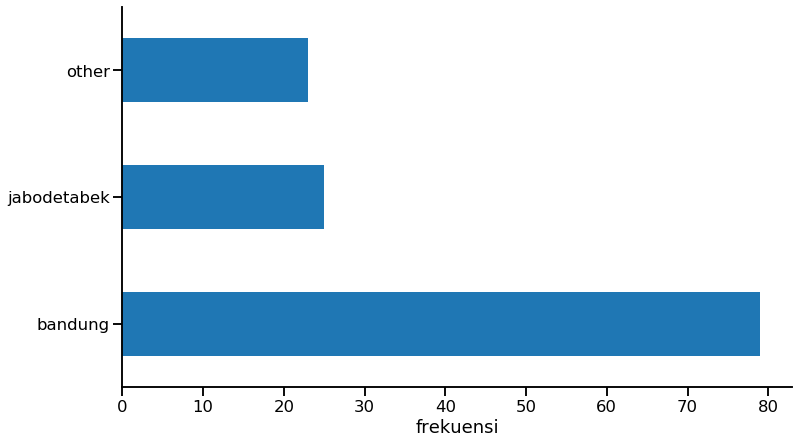

In [11]:
df['domisili'].value_counts().plot.barh()
plt.xlabel('frekuensi')
sns.despine()

Pada hasil eksplorasi data survey sebelumnya dikatakan bahwa responden >30 dan grouping yang relatif seragam bisa menjadi *magic number* untuk mengesahkan bahwa survey itu representatif. Apakah data dari survey ini bisa representatif? Atau hanya bisa memperdalam analisa wilayah Bandung?

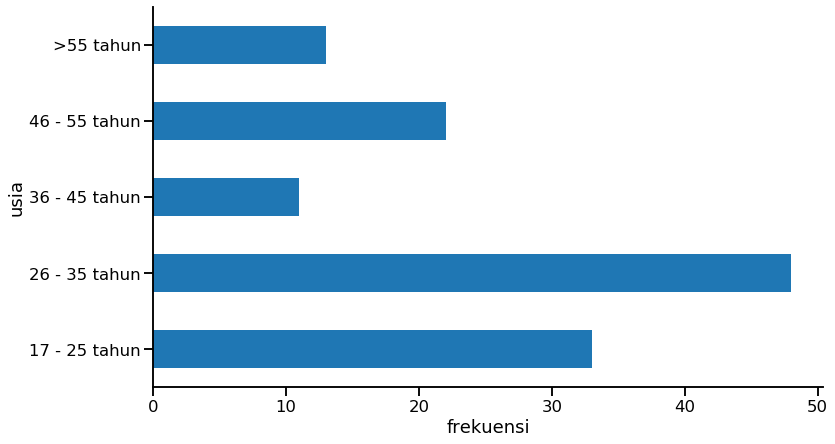

In [7]:
df.loc[df['domisili'] != 'bandung','Usia'].value_counts().sort_index().plot.barh()
plt.xlabel('frekuensi')
plt.ylabel('usia')
sns.despine()

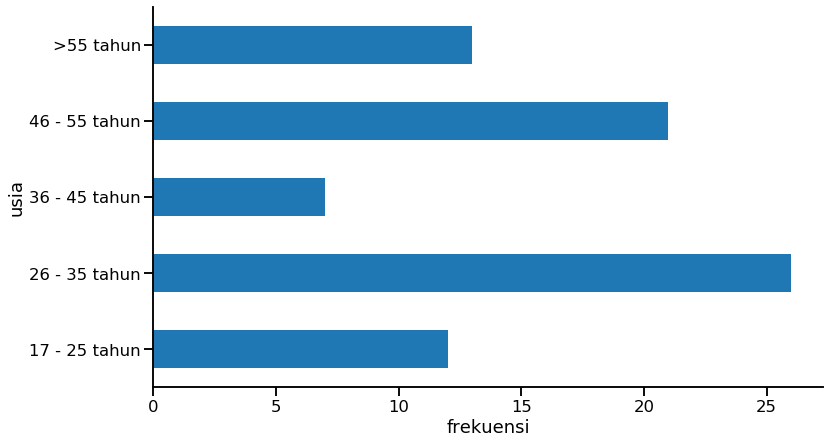

In [12]:
df.loc[df['domisili'] == 'bandung','Usia'].value_counts().sort_index().plot.barh()
plt.xlabel('frekuensi')
plt.ylabel('usia')
sns.despine()

Hal yang menarik disini adalah bahwa responden berdasarkan usia di Bandung lebih seragam dibandingkan pada domisili lainnya maupun dari data survey sebelumnya. Kecuali pada usia 35-45 tahun yang frekuensinya jauh lebih rendah dari kelompok usia lainnya

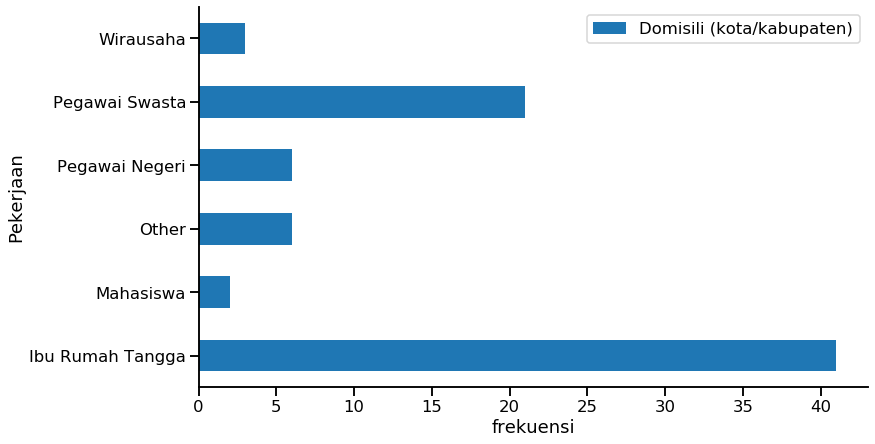

In [13]:
dfb = df.loc[df['domisili'] == 'bandung']
dfb[['Domisili (kota/kabupaten)','Pekerjaan']].groupby('Pekerjaan').count().plot.barh()
plt.xlabel('frekuensi')
sns.despine()

In [14]:
bekerja = [
    'mahasiswa',
    'pegawai negeri',
    'pegawai swasta',
    'wirausaha'
]

conditions = [
    dfb['Pekerjaan'].str.lower().isin(bekerja),
    dfb['Pekerjaan'].str.lower() == 'ibu rumah tangga'
]

choices = [
    'bekerja',
    'ibu rumah tangga'
]

dfb['bekerja'] = np.select(conditions, choices, default='other')

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


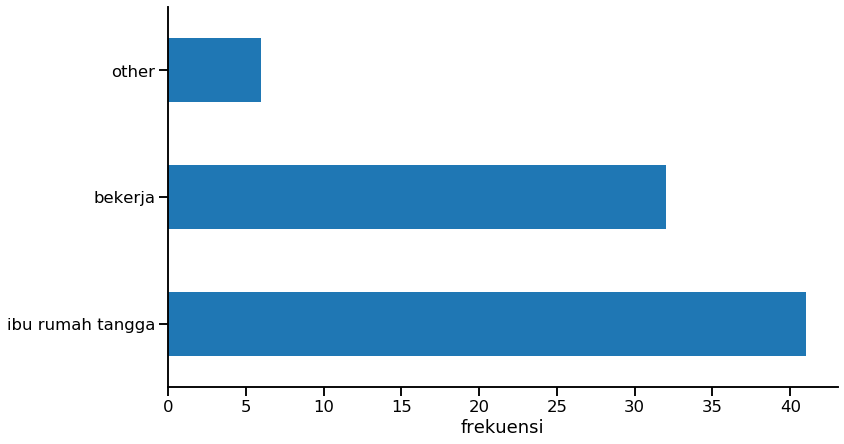

In [15]:
dfb['bekerja'].value_counts().plot.barh()
plt.xlabel('frekuensi')
sns.despine()

Ketika 'Pekerjaan' dibagi menjadi dua golongan antara responden yang bekerja dan ibu rumah tangga, ternyata pambagiannya cukup seimbang. Oleh karena itu saya ingin mencoba mencari tahu lebih dalam tentang perbedaan *behavior* mereka

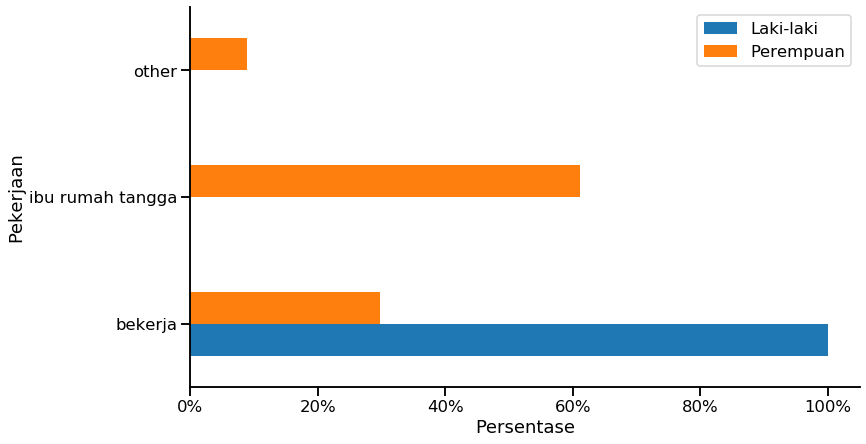

In [16]:
pivoted = dfb.pivot_table(
    values='Usia',
    index='Jenis kelamin',
    columns='bekerja',
    aggfunc='count',
    fill_value=0
)
ax = pivoted.divide(pivoted.sum(axis=1), axis=0).T.plot.barh()
plt.legend()
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])
plt.xlabel('Persentase')
plt.ylabel('Pekerjaan')
sns.despine()

In [17]:
expense_cols = [
    '< Rp. 500.000',
    'Rp. 500.000 - Rp. 1.000.000',
    'Rp. 1.000.000 - Rp. 2.500.000',
    'Rp. 2.500.000 - Rp. 5.000.000',
    '> Rp. 5.000.000'
]

In [18]:
dfb[dfb['bekerja'] != 'other'].pivot_table(
    values = 'Jenis kelamin',
    index = ['bekerja', 'Usia'],
    columns = 'Pengeluaran yang Anda keluarkan selama 1 bulan',
    aggfunc = 'count',
    fill_value = 0
)[expense_cols].T.style.background_gradient()

Kalau dari pengeluaran sepertinya tidak terlihat perbedaan yang ekstrim antara responden yang bekerja dengan ibu rumah tangga.

Yang perlu menjadi catatan profil pengeluaran dari pengisi kuisioner sangat didominasi oleh responden dengan pengeluaran lebih dari Rp 2.500.000 per bulan. Data responden dengan pengeluaran yang lebih kecil dari 2.500.000 akan kurang representatif. Oleh karena itu responden akan di kelompokkan lagi berdasarkan pengeluarannya menjadi dua kelompok yaitu:
1. kelompok pengeluaran rendah-sedang
2. kelompok pengeluaran tinggi

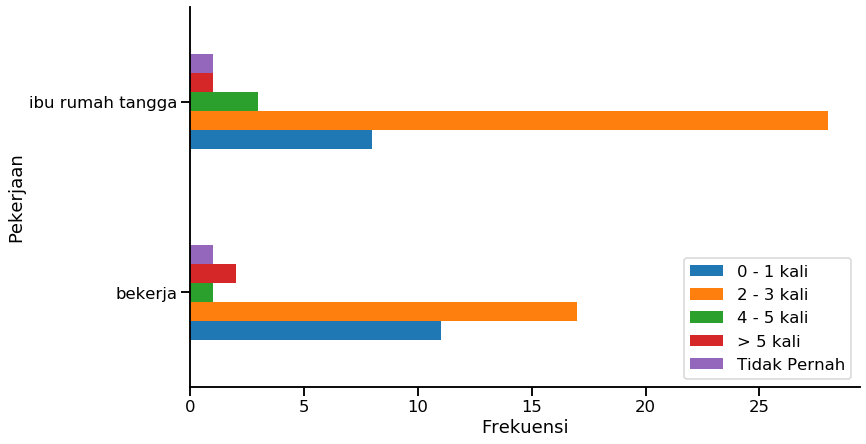

In [19]:
pivoted = dfb[dfb['bekerja'] != 'other'].pivot_table(
    values = 'Jenis kelamin',
    index = 'bekerja',
    columns = 'Dalam seminggu, seberapa sering Anda mengonsumsi Produk Perikanan?',
    aggfunc = 'count',
    fill_value = 0
)
ax = pivoted.plot.barh()
plt.legend()
vals = ax.get_xticks()
plt.xlabel('Frekuensi')
plt.ylabel('Pekerjaan')
sns.despine()

In [20]:
pengeluaran_tinggi = [
    '> Rp. 5.000.000',
    'Rp. 2.500.000 - Rp. 5.000.000'
]

pengeluaran_rendah_sedang = [
    '< Rp. 500.000',
    'Rp. 500.000 - Rp. 1.000.000',
    'Rp. 1.000.000 - Rp. 2.500.000',
    'Rp. 2.500.000 - Rp. 5.000.000'  
]

conditions = [
    dfb['Pengeluaran yang Anda keluarkan selama 1 bulan'].isin(pengeluaran_tinggi),
    dfb['Pengeluaran yang Anda keluarkan selama 1 bulan'].isin(pengeluaran_rendah_sedang)
]

choices = [
    'pengeluaran tinggi',
    'pengeluaran rendah-sedang'
]

dfb['pengeluaran'] = np.select(conditions, choices, default='other')

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


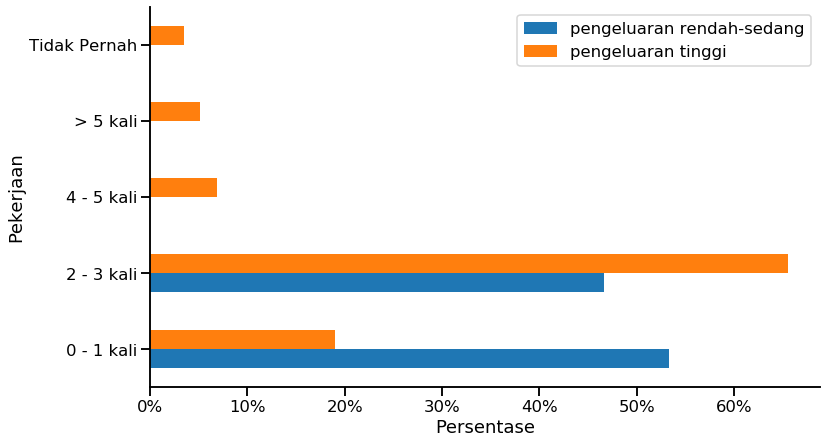

In [21]:
pivoted = dfb[dfb['bekerja'] != 'other'].pivot_table(
    values = 'Jenis kelamin',
    index = 'pengeluaran',
    columns = 'Dalam seminggu, seberapa sering Anda mengonsumsi Produk Perikanan?',
    aggfunc = 'count',
    fill_value = 0
)
ax = pivoted.divide(pivoted.sum(axis=1), axis=0).T.plot.barh()
plt.legend()
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0%}'.format(x) for x in vals])
plt.xlabel('Persentase')
plt.ylabel('Pekerjaan')
sns.despine()

In [22]:
fresh_food = dfb.loc[:,'fresh_food'] = dfb.loc[:,'Jenis pengolahan ikan yang Anda minati'].str.contains('Fresh')

frozen_food = dfb.loc[:,'frozen_food'] = dfb.loc[:,'Jenis pengolahan ikan yang Anda minati'].str.contains('Frozen')

canned_food = dfb.loc[:,'canned_food'] = dfb.loc[:,'Jenis pengolahan ikan yang Anda minati'].str.contains('Canned')

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
print('Pilihan olahan ikan ibu rumah tangga:')
print('Fresh: {:.1%}'.format(dfb[dfb['bekerja'] == 'ibu rumah tangga'].loc[:,'fresh_food'].mean()))
print('Frozen: {:.1%}'.format(dfb[dfb['bekerja'] == 'ibu rumah tangga'].loc[:,'frozen_food'].mean()))
print('Canned: {:.1%}'.format(dfb[dfb['bekerja'] == 'ibu rumah tangga'].loc[:,'canned_food'].mean()))

print('\n')
print('Pilihan olahan ikan responden yang bekerja:')
print('Fresh: {:.1%}'.format(dfb[dfb['bekerja'] == 'bekerja'].loc[:,'fresh_food'].mean()))
print('Frozen: {:.1%}'.format(dfb[dfb['bekerja'] == 'bekerja'].loc[:,'frozen_food'].mean()))
print('Canned: {:.1%}'.format(dfb[dfb['bekerja'] == 'bekerja'].loc[:,'canned_food'].mean()))